<div style="background-color:white">
  <div align="center">
    <img src="https://www.fau.de/wp-content/themes/FAU-Einrichtungen/img/logos/fau-logo-240x65.svg" width="400" height="250">
    <hr>
    <h1 style="color:black">SAKI Assignment 1 - Naive Bayes Classifier<h1>
    <h2>Tim Löhr</h2>
  </div>
  <hr>
</div>

### Background:

This project aims to quantify how accurately bank transfer data can classify different labels. Those labels are for example standard of living or income. Different data from the bank transfer could have an indication for which label this payment aims for. 


### Objective:
**Transaction Classification:** 

Using a real dataset from the master course `Software Applications with Artificial Intelligence`, I try to predict based on bank transfer data, how accurately I can predict a given label. For this project, I analyise all the features given to us and underdo different preprocessing techniques, because we have categorical data, numbers and also text. 
I try out different combinations with the data and use the naive bayes classifier for the classification task.
Furthermore, the dataset is split into a train, test and validation set, because of the slight data imbalance.
In the end, the trained model will be evaluated based on the accuracy and F1 score, because we have a multiclass classification task which is imbalanced. Therefore only the accuracy score is not sufficient enough to evaluate the result.

### `Outline of the Notebook`

- [0. Import Packages](#0)

- [1. Data Analysis](#1)
    - [1.1 Labels](#1.1)
    - [1.2 Missing Data](#1.2)
    - [1.3 Features](#1.3)
        - [1.3.1 Auftragskonto](#1.3.1)
        - [1.3.2 Valutadatum](#1.3.2)
        - [1.3.3 Buchungstext](#1.3.3)
        - [1.3.4 Kontonummer](#1.3.4)
        - [1.3.5 BLZ](#1.3.5)
        - [1.3.6 Plus Minus Betrag](#1.3.6)
        - [1.3.7 Verwendungszweck](#1.3.7)
    - [1.4 Combining Features](#1.4)
        
- [2. Model Training](#2)
    
- [3. Model Evaluation](#3)
    - [2.1 Train, Test and Validation Accuracy](#3.1)
    - [2.2 Train, Test and Validation F1-Score](#3.2)

<a name='0.0'></a>
# 0.0 Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import PowerTransformer

import spacy
from spacy import displacy
from collections import Counter
from yellowbrick.classifier import ClassificationReport

import en_core_web_sm
nlp = en_core_web_sm.load()

# Set plotting options
%matplotlib inline
plt.rc('figure', figsize=(16, 5))
plt.style.use('ggplot')
sns.set(font_scale=1.25)
pd.set_option('display.max_rows', 500)

<a name='1.0'></a>
# 1.0 Data Analysis

In [2]:
df = pd.read_csv("data.csv", sep=";")
df.drop(columns=["Unnamed: 0"], inplace=True)
print(f"df shape: {df.shape}")

df shape: (209, 11)


In [3]:
df.head()

,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung,label
0,89990201.0,28.07.2016,28.07.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,25190001,2000.00,EUR,income
1,89990201.0,27.07.2016,27.07.2016,Miete,Byladem1Sbt De12773501123456789889 Miete Beuth...,Georg Tasche,DE31251900019123456780,VOHADE2HXXX,-670.00,EUR,living
2,89990201.0,21.07.2016,21.07.2016,Bargeld,"21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,9999900780,25190001,-70.00,EUR,private
3,89990201.0,20.07.2016,20.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20...,Kartenzahlung,9736000780,25190001,-73.21,EUR,standardOfLiving
4,89990201.0,18.07.2016,18.07.2016,Spontanausgabe,Amazon,neue Playstation,9988776655,25125100,-363,EUR,leisure


<a name='1.1'></a>
## 1.1 Labels

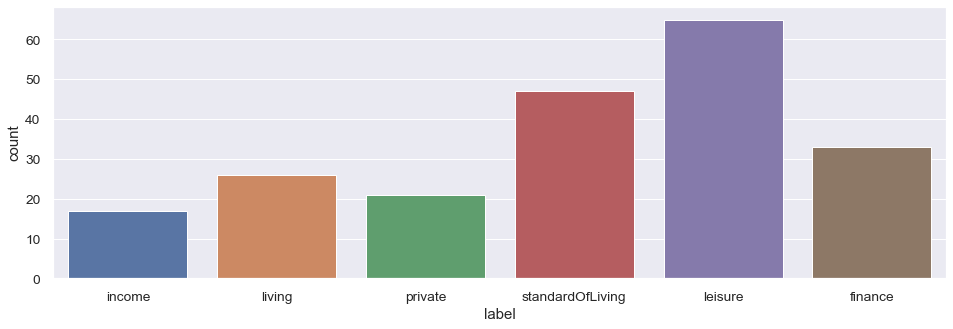

In [4]:
sns.countplot(data=df, x="label")
plt.show()

In [5]:
for col in df:
    print("{:40s} number of unique features: {}".format(col, df[col].nunique()))

Auftragskonto                            number of unique features: 2
Buchungstag                              number of unique features: 85
Valutadatum                              number of unique features: 85
Buchungstext                             number of unique features: 14
Verwendungszweck                         number of unique features: 125
Beguenstigter/Zahlungspflichtiger        number of unique features: 59
Kontonummer                              number of unique features: 53
BLZ                                      number of unique features: 40
Betrag                                   number of unique features: 94
Waehrung                                 number of unique features: 1
label                                    number of unique features: 6


<a name='1.2'></a>
## 1.2 Missing Data

<AxesSubplot:>

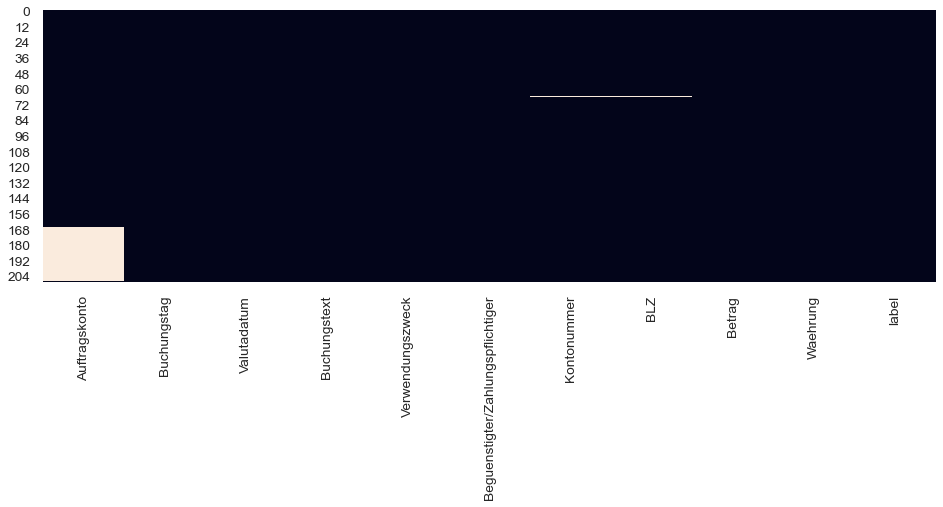

In [6]:
sns.heatmap(df.isna(), cbar=False)

#### Drop the row with the many missing values. Auftragskonto can be ignored

In [7]:
df[df["BLZ"].isna() == True]

,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung,label
66,89990210.0,31.03.2016,31.03.2016,Abschluss,Abschluss,Abschluss,NaN,NaN,"60,04",EUR,finance


In [8]:
df.drop(df.index[[66]], inplace=True)

<a name='1.3'></a>
## 1.3 Features

<a name='2.2.1'></a>
### 1.3.1 Feature: Auftragskonto

In [9]:
df["Auftragskonto"].value_counts()

89990210.0    119
89990201.0     48
Name: Auftragskonto, dtype: int64

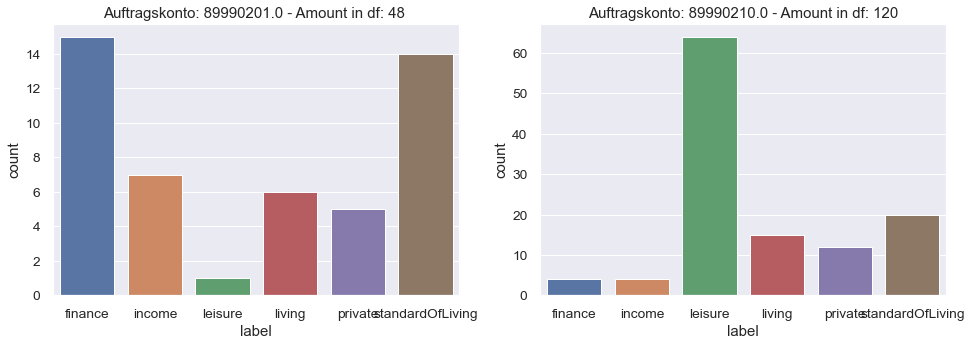

In [10]:
groups = df.groupby(["Auftragskonto", "label"]).count()["BLZ"].reset_index().rename(columns={"BLZ": "count"})
ak1 = groups[groups["Auftragskonto"] == 89990201.0]
ak2 = groups[groups["Auftragskonto"] == 89990210.0]

fig, (ax1, ax2) = plt.subplots(1, 2)

sns.barplot(data=ak1, x="label", y="count", ax=ax1)
sns.barplot(data=ak2, x="label", y="count", ax=ax2)
ax1.set_title("Auftragskonto: 89990201.0 - Amount in df: 48 ")
ax2.set_title("Auftragskonto: 89990210.0 - Amount in df: 120")
plt.show()

<a name='1.3.2'></a>
### 1.3.2 Feature: Valutadatum

`Valutadatum appears to have no value, because no pattern can be seen`

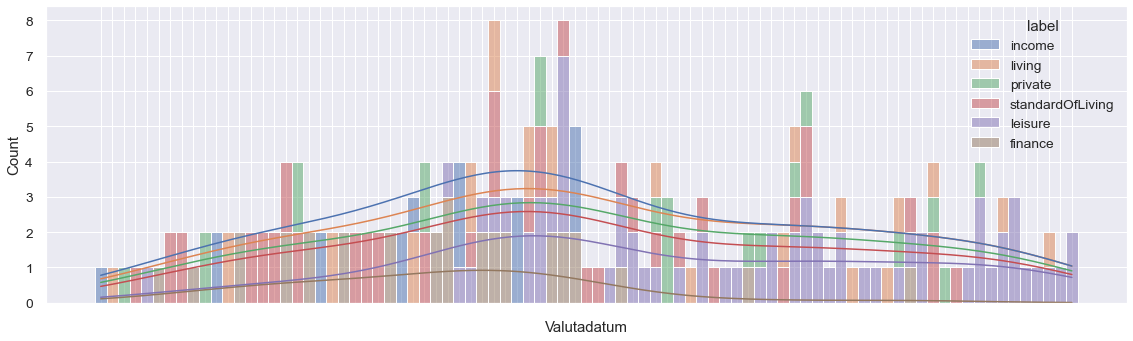

In [11]:
g = sns.histplot(data=df, 
             x="Valutadatum", 
             hue="label", 
             multiple="stack",
             kde=True)

g.set(xticklabels=[])
plt.tight_layout()
plt.show()

<a name='1.3.3'></a>
### 1.3.3 Feature: Buchungstext

`This means, that for our 13 unique Buchungstexte, only 6 (19-13) are used for multiple labels. So most labels have a unique Buchungstext. This should be highly valueable for our prediction`

In [12]:
buchungstext_unique = df.groupby(["label", "Buchungstext"]).count().reset_index()
print(f"All Buchungstexte: {len(buchungstext_unique['Buchungstext'])}")
print(f"Unique Buchungstexte: {buchungstext_unique['Buchungstext'].nunique()}")

All Buchungstexte: 19
Unique Buchungstexte: 13


<a name='1.3.4'></a>
### 1.3.4 Feature: Kontonummer

`It appears, that each Kontonummer has only one specific label. This seems as a very valueable feature`

In [13]:
kontonummer_unique = df.groupby(["label", "Kontonummer"]).count().reset_index()
print(f"All Kontonummern: {len(kontonummer_unique['Kontonummer'])}")
print(f"Unique Kontonummern: {kontonummer_unique['Kontonummer'].nunique()}")

All Kontonummern: 53
Unique Kontonummern: 53


<a name='1.3.5'></a>
### 1.3.5 Feature: BLZ

In [14]:
blz_unique = df.groupby(["label", "BLZ"]).count().reset_index()
print(f"All blz: {len(blz_unique['BLZ'])}")
print(f"Unique blz: {blz_unique['BLZ'].nunique()}")

All blz: 44
Unique blz: 40


<a name='1.3.6'></a>
### 1.3.6 Feature: Plus Minus Betrag

In [15]:
train_minus_plus = df["Betrag"].copy().apply(lambda x: x.replace(",", ".")).apply(lambda x: x.split(".")[0]).astype(int).apply(lambda x: 1 if x > 0 else 0).copy()

df["Betrag_int"] = df["Betrag"].apply(lambda x: x.replace(",", ".")).apply(lambda x: x.split(".")[0]).astype(int)
bins = [-5000, -2500, -500, -50, 0, 50, 500, 2500, 5000]
train_betrag = pd.get_dummies(pd.cut(x=df["Betrag_int"], bins=bins)).copy()

print(f"Max: {df['Betrag_int'].max()}")
print(f"Min: {df['Betrag_int'].min()}")
print(f"Mean: {np.round(df['Betrag_int'].mean(), 2)}")
print(train_betrag.shape)

Max: 2986
Min: -5000
Mean: 3.94
(208, 8)


<a name='1.3.7'></a>
### 1.3.7 Feature: Verwendungszweck

In [16]:
def clean_text(text):
    text=re.sub('<.*?>', ' ', text)  
    text = ''.join([i for i in text if not i.isdigit()])
    text = re.sub("\n"," ",text)
    text = text.replace('End-To-End-Ref', '')
    text = ' '.join(text.split())
    return text

In [17]:
vocabulary = []

for i in range(len(df)):
    doc = nlp(clean_text(df["Verwendungszweck"].iloc[i]))
    for ent in doc.ents:
        vocabulary.append(str(ent).strip())
    
vocabulary = set(list(vocabulary))
vocabulary = list(set([sub.replace('End-To-End-Ref', '') for sub in vocabulary]))

In [18]:
vocab_df = pd.DataFrame(columns=vocabulary)
concat_df = pd.concat([df, vocab_df]).fillna(0)

In [19]:
for i in range(len(df)):
    zweck = df["Verwendungszweck"].iloc[i]
    cleaned = nlp(clean_text(zweck))
    for ent in cleaned.ents:
        concat_df.loc[i, str(ent)] += 1

<a name='1.4'></a>
## 1.4 Combining Features

In [20]:
train_bt = pd.get_dummies(df["Buchungstext"], prefix="Buchungstext")
train_kn = pd.get_dummies(df["Kontonummer"], prefix="Kontonummer")
train_blz = pd.get_dummies(df["BLZ"], prefix="BLZ")
train_bz = pd.get_dummies(df["Beguenstigter/Zahlungspflichtiger"], prefix="Beguenstigter/Zahlungspflichtiger")
train_vz = concat_df[vocabulary]

train_data = pd.concat([train_bt, train_kn, train_blz, train_minus_plus] , axis=1)
train_label = pd.DataFrame(pd.factorize(df["label"])[0])

<a name='2.0'></a>
# 2.0 Model Training

In [21]:
flatten = lambda t: [item for sublist in t for item in sublist]

In [22]:
temp_df = pd.concat([train_data, train_label], axis=1).fillna(0).astype(int)

test_set_indices = []

for label in set(temp_df[0]):
    test_set_indices.append(list(np.random.choice(temp_df[temp_df[0] == label].index, 5, replace=False)))
    
test_set_indices = flatten(test_set_indices)

test_df = temp_df.iloc[test_set_indices]
temp_df.drop(test_set_indices, inplace=True)

# +1, because of the one dropped row in the beginning
assert (len(test_df) + len(temp_df) == len(df) + 1), "Something went wrong"

In [23]:
y_test = test_df[0]
X_test = test_df.drop(columns=[0])

In [24]:
X_train, X_val, y_train, y_val = train_test_split(train_data, 
                                                  train_label, 
                                                  stratify=train_label,
                                                  test_size=0.3)


print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")

train_strat = y_train.value_counts() / np.sum(y_train.value_counts())
val_strat = y_val.value_counts() / np.sum(y_val.value_counts())
strat = train_strat / val_strat

assert (all(strat >= 0.8) == True) & (all(strat <= 1.2) == True), "The Stratify didn't work"

X_train: (145, 107)
X_val: (63, 107)


In [25]:
#priors = list(train_label.value_counts() / len(train_label))

In [26]:
y_train = np.array(y_train).reshape(-1,)
y_val = np.array(y_val).reshape(-1,)


clf = GaussianNB()

cv_method = RepeatedStratifiedKFold(n_splits=20, 
                                    n_repeats=5, 
                                    random_state=999)

params_KNN = {'var_smoothing': np.logspace(0,-5, num=100)}

gs_nb = GridSearchCV(estimator=clf, 
                      param_grid=params_KNN, 
                      cv=cv_method,
                      verbose=1,  # verbose: the higher, the more messages
                      scoring='accuracy', 
                      return_train_score=True)

In [27]:
#Data_transformed = PowerTransformer().fit_transform(X_train)

gs_nb.fit(X_train, y_train)

Fitting 100 folds for each of 100 candidates, totalling 10000 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 12 members, which is less than n_splits=20.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 12 members, which is less than n_splits=20.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 12 members, which is less than n_splits=20.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 12 members, which is less than n_splits=20.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: T

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=20, random_state=999),
             estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.90215085e-01, 7.92482898e-01, 7.05480231e-01,
       6.28029144e-01, 5.59081018e-01, 4.97702356e-01, 4.43062146e-01,
       3.94420606e-01, 3.51119173e-01, 3.12571585e-01, 2.78255940e-01,
       2.47707636e-01, 2.20513074e-01,...
       9.11162756e-05, 8.11130831e-05, 7.22080902e-05, 6.42807312e-05,
       5.72236766e-05, 5.09413801e-05, 4.53487851e-05, 4.03701726e-05,
       3.59381366e-05, 3.19926714e-05, 2.84803587e-05, 2.53536449e-05,
       2.25701972e-05, 2.00923300e-05, 1.78864953e-05, 1.59228279e-05,
       1.41747416e-05, 1.26185688e-05, 1.12332403e-05, 1.00000000e-05])},
             return_train_score=True, scoring='accuracy', verbose=1)

<a name='3.0'></a>
# 3.0 Model Evaluation

In [28]:
classes = ["income", "living", "private", "standardOfLiving", "leisure", "finance"]

In [29]:
gs_nb.best_params_

{'var_smoothing': 0.08697490026177834}

In [30]:
gs_nb.best_score_

0.96125

In [31]:
gs_nb.cv_results_['mean_test_score'][::10]

array([0.86964286, 0.92446429, 0.96125   , 0.93446429, 0.93446429,
       0.94267857, 0.92375   , 0.92375   , 0.92375   , 0.92375   ])

In [32]:
results_NB = pd.DataFrame(gs_nb.cv_results_['params'])
results_NB['test_score'] = gs_nb.cv_results_['mean_test_score']

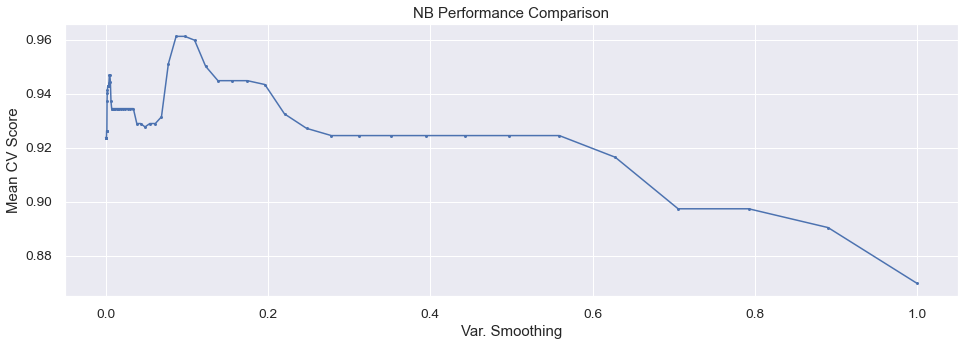

In [33]:
plt.plot(results_NB['var_smoothing'], results_NB['test_score'], marker = '.')    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")
plt.show()

<a name='3.1'></a>
## 3.1 Train, Test and Validation Accuracy

In [34]:
print(f"Train Accuracy: {accuracy_score(gs_nb.predict(X_train), y_train)}")
print(f"Validation Accuracy: {np.round(accuracy_score(gs_nb.predict(X_val), y_val), 2)}")
print(f"Test Accuracy: {np.round(accuracy_score(gs_nb.predict(X_test), y_test), 2)}")

Train Accuracy: 1.0
Validation Accuracy: 0.92
Test Accuracy: 0.5


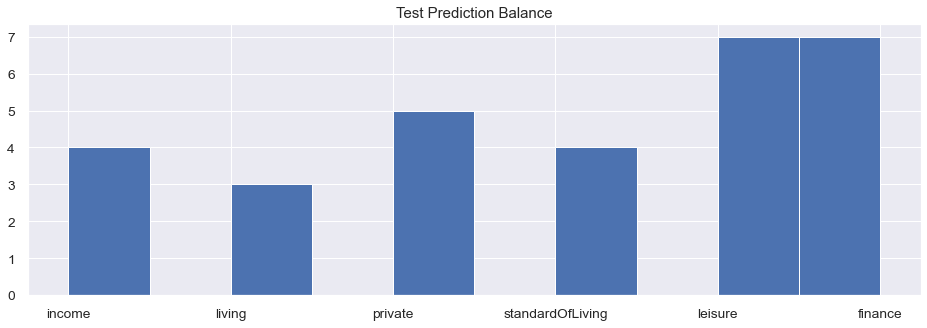

In [35]:
plt.hist(gs_nb.predict(X_test))
plt.title("Test Prediction Balance")
plt.xticks([0, 1, 2, 3, 4, 5], classes)
plt.show()

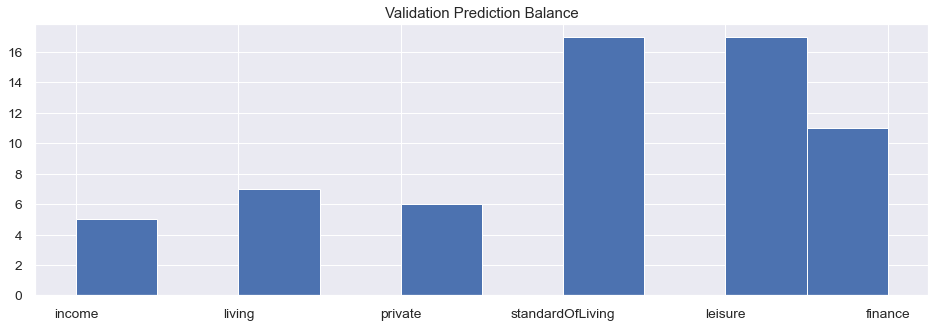

In [36]:
plt.hist(gs_nb.predict(X_val))
plt.title("Validation Prediction Balance")
plt.xticks([0, 1, 2, 3, 4, 5], classes)
plt.show()

<a name='3.2'></a>
## 3.2 Train, Test and Validation F1-Score

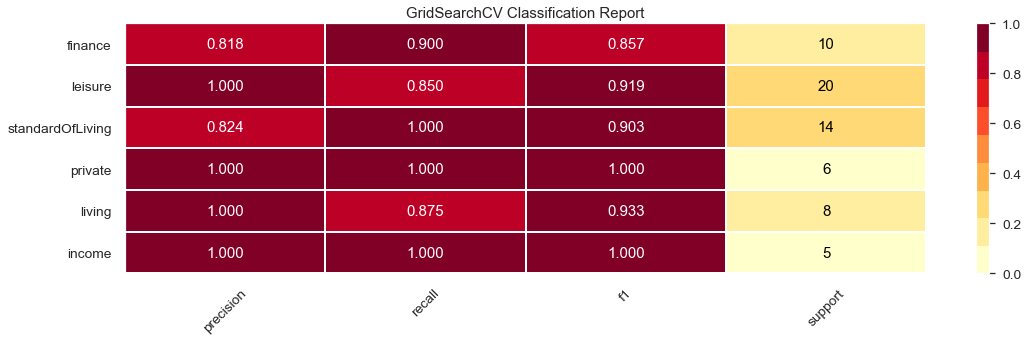

<AxesSubplot:title={'center':'GridSearchCV Classification Report'}>

In [37]:
# Validation Set
visualizer = ClassificationReport(gs_nb, classes=classes, support=True)

visualizer.fit(X_train, y_train)     
visualizer.score(X_val, y_val)        
visualizer.show()  

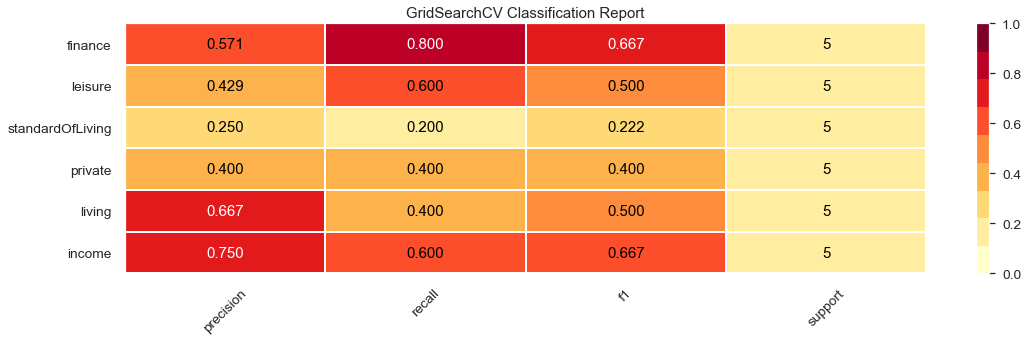

<AxesSubplot:title={'center':'GridSearchCV Classification Report'}>

In [38]:
# Test Set
visualizer = ClassificationReport(gs_nb, classes=classes, support=True)

visualizer.fit(X_train, y_train)     
visualizer.score(X_test, y_test)        
visualizer.show()  